<font color = blue><font size = 6> HDLSTM(Trend) </font></font><br>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [38]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [39]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


In [40]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':16,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel/online_learning_seq2seq']

In [41]:
class Trend_Encoder(nn.Module):
    def __init__(self,configs):
        super(Trend_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden

In [42]:
class Trend_Decoder(nn.Module):
    def __init__(self,configs):
        super(Trend_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)

        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [43]:
tup= (1,2)
len(tup)

2

In [44]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [45]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [46]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.device = torch.device('cuda:0')
        self.trend_encoder = Trend_Encoder(configs)
        self.trend_decoder = Trend_Decoder(configs)
        
        self.Linear_Seasonal = nn.Linear(1440,1)
        
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        
    def forward(self,x):
        div_factor = x[:,-1,:].view(-1,1,1)
        x = x/div_factor
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        x = x.permute(0,2,1)
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.permute(0,2,1).to(self.device) 

        _,final_trend_hidden = self.trend_encoder(trend_init)
        trend_output,_ = self.trend_decoder(x = trend_init[:,-1,:].view(-1,1,1),encoder_hidden = final_trend_hidden)
        season_output = self.Linear_Seasonal(seasonal_init)
        
        output = (trend_output+season_output)*div_factor
        
        return output,season_output,trend_output

In [47]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [48]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [49]:
x_seq

tensor([[[0.2202, 0.2216, 0.2057,  ..., 0.2027, 0.1702, 0.1716]],

        [[0.2216, 0.2057, 0.1852,  ..., 0.1702, 0.1716, 0.2092]],

        [[0.2057, 0.1852, 0.1735,  ..., 0.1716, 0.2092, 0.2202]],

        ...,

        [[0.1641, 0.1660, 0.1776,  ..., 0.1784, 0.1696, 0.1720]],

        [[0.1660, 0.1776, 0.2252,  ..., 0.1696, 0.1720, 0.1768]],

        [[0.1776, 0.2252, 0.2034,  ..., 0.1720, 0.1768, 0.1615]]],
       device='cuda:0')

In [50]:
target

tensor([[[0.2092]],

        [[0.2202]],

        [[0.2011]],

        ...,

        [[0.1768]],

        [[0.1615]],

        [[0.1736]]], device='cuda:0')

In [51]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-03.


In [52]:
torch.manual_seed(42)

In [53]:
x_seq

tensor([[[0.2202, 0.2216, 0.2057,  ..., 0.2027, 0.1702, 0.1716]],

        [[0.2216, 0.2057, 0.1852,  ..., 0.1702, 0.1716, 0.2092]],

        [[0.2057, 0.1852, 0.1735,  ..., 0.1716, 0.2092, 0.2202]],

        ...,

        [[0.1641, 0.1660, 0.1776,  ..., 0.1784, 0.1696, 0.1720]],

        [[0.1660, 0.1776, 0.2252,  ..., 0.1696, 0.1720, 0.1768]],

        [[0.1776, 0.2252, 0.2034,  ..., 0.1720, 0.1768, 0.1615]]],
       device='cuda:0')

In [54]:
out_list = []
loss_list = []
ss_list = []
tr_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
#         print(seq)
        out,ss,tr = model(seq)
#         print(out)
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        ss_list.append(ss)
        tr_list.append(tr)
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 9.5000e-04.
smape 18.49307075447855 %
Adjusting learning rate of group 0 to 9.0250e-04.
smape 21.65131549606895 %
Adjusting learning rate of group 0 to 8.5737e-04.
smape 20.718929951041066 %
Adjusting learning rate of group 0 to 8.1451e-04.
smape 18.609167596227245 %
Adjusting learning rate of group 0 to 7.7378e-04.
smape 18.76257261686158 %
Adjusting learning rate of group 0 to 7.3509e-04.
smape 18.23378063259069 %
Adjusting learning rate of group 0 to 6.9834e-04.
smape 17.09926431247017 %
Adjusting learning rate of group 0 to 6.6342e-04.
smape 15.545482754881618 %
Adjusting learning rate of group 0 to 6.3025e-04.
smape 15.837081953534607 %
Adjusting learning rate of group 0 to 5.9874e-04.
smape 15.81780169834519 %
Adjusting learning rate of group 0 to 5.6880e-04.
smape 14.914051283434121 %
Adjusting learning rate of group 0 to 5.4036e-04.
smape 14.54420256422974 %
Adjusting learning rate of group 0 to 5.1334e-04.
smape 13.21993811829397 %
Adjusti

In [55]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out,_,_ = model(new_train) # 예측완료

        loss = criterion(out,tg)# 예측값과 타겟값의 비교

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out,_,_ = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.8937351932981983 %
SMAPE 12.365604028105736 %
SMAPE 4.837718369290087 %
SMAPE 0.12326718239273761 %
SMAPE 0.13137683677905443 %
SMAPE 2.3586515158676775 %
SMAPE 1.4231792804639554 %
SMAPE 2.5049550077237654 %
SMAPE 3.563233564607799 %
SMAPE 0.43342117105885336 %
SMAPE 0.17211884849001535 %
SMAPE 0.3039476718242895 %
SMAPE 8.618423003703356 %
SMAPE 0.578442584574077 %
SMAPE 6.482062596827745 %
SMAPE 7.531961135566235 %
SMAPE 2.705410154942001 %
SMAPE 13.000513941049578 %
SMAPE 2.681533704276262 %
SMAPE 0.2830319100705765 %
SMAPE 14.28120569884777 %
SMAPE 0.7132549464513431 %
SMAPE 9.965150199830532 %
SMAPE 1.5889233091911592 %
SMAPE 16.528625264763832 %
SMAPE 3.0363477026403416 %
SMAPE 0.14953489545280263 %
SMAPE 0.4150116367254668 %
SMAPE 0.4142138847792012 %
SMAPE 4.2392632724076975 %
SMAPE 2.484776648103434 %
SMAPE 10.748696088790894 %
SMAPE 0.833752270307741 %
SMAPE 7.007761333137751 %
SMAPE 0.7845385189793888 %
SMAPE 9.850275117903948 %
SMAPE 3.154725297536061 %
SMAPE 3.606

SMAPE 4.744437830522656 %
SMAPE 1.9686440325258445 %
SMAPE 1.752358848185395 %
SMAPE 0.20130512577418358 %
SMAPE 8.444878991693258 %
SMAPE 10.83916924148798 %
SMAPE 2.190997527446598 %
SMAPE 29.09542116522789 %
SMAPE 14.169504113495348 %
SMAPE 0.06853711395723394 %
SMAPE 7.474149134010076 %
SMAPE 8.800831727683544 %
SMAPE 0.10890517346524575 %
SMAPE 0.3054758002554081 %
SMAPE 2.3640613548996043 %
SMAPE 1.5732985514914617 %
SMAPE 0.05099025842400806 %
SMAPE 0.6024102153114654 %
SMAPE 0.020775237104743383 %
SMAPE 7.481135182082653 %
SMAPE 0.2649526431750928 %
SMAPE 16.84810508787632 %
SMAPE 1.8368882161103102 %
SMAPE 0.504135746978136 %
SMAPE 10.400398261845112 %
SMAPE 1.1432859872338668 %
SMAPE 3.8274559375131503 %
SMAPE 2.2754578364401823 %
SMAPE 2.1842971190199023 %
SMAPE 0.9353818169365695 %
SMAPE 2.5935743439622456 %
SMAPE 1.083074624705091 %
SMAPE 0.6919603858041228 %
SMAPE 1.8022576912810566 %
SMAPE 0.04512447525371499 %
SMAPE 5.216770643368363 %
SMAPE 3.871602916624397 %
SMAPE 18

SMAPE 0.3550613878783224 %
SMAPE 0.6893001840791158 %
SMAPE 1.3425268745146752 %
SMAPE 0.13898574567861033 %
SMAPE 0.3003981518801311 %
SMAPE 5.395108910277486 %
SMAPE 1.1710928703864738 %
SMAPE 2.152696266741259 %
SMAPE 0.9746599524296471 %
SMAPE 0.36429939889148955 %
SMAPE 0.22554362997709632 %
SMAPE 2.471371571009513 %
SMAPE 6.053770484402776 %
SMAPE 1.0442100748168741 %
SMAPE 4.606723539531231 %
SMAPE 9.179872155189514 %
SMAPE 0.028048510810094737 %
SMAPE 9.18297240883112 %
SMAPE 4.4794332683086395 %
SMAPE 0.44014483598402876 %
SMAPE 0.30978850596738994 %
SMAPE 3.8784810500219464 %
SMAPE 1.442099210962624 %
SMAPE 2.5646844627626706 %
SMAPE 4.13482453674078 %
SMAPE 0.6498713967448566 %
SMAPE 3.118420916427567 %
SMAPE 6.981339514255523 %
SMAPE 0.670278041893198 %
SMAPE 0.9342027363045418 %
SMAPE 1.2194983030376534 %
SMAPE 3.7469674479216333 %
SMAPE 10.951345391571522 %
SMAPE 1.874949800680042 %
SMAPE 3.820337230339646 %
SMAPE 2.1540285468654474 %
SMAPE 0.011949593129600089 %
SMAPE 0.

SMAPE 1.7796676625985128 %
SMAPE 4.320937293581665 %
SMAPE 3.6517735510133207 %
SMAPE 3.8499625655822456 %
SMAPE 0.46361951349150843 %
SMAPE 0.4040229914966176 %
SMAPE 0.2793187176023366 %
SMAPE 3.626400872250088 %
SMAPE 0.28503128945249046 %
SMAPE 1.2603397616294387 %
SMAPE 10.336843878030777 %
SMAPE 0.7788513734282105 %
SMAPE 0.6493880958350928 %
SMAPE 0.17349441088242656 %
SMAPE 1.0144018659420908 %
SMAPE 0.6652157474063642 %
SMAPE 0.3412032032342722 %
SMAPE 2.5468454016227042 %
SMAPE 4.684225198812783 %
SMAPE 0.45536512164562737 %
SMAPE 0.11650040341373824 %
SMAPE 0.42985145260490754 %
SMAPE 0.6511776574727719 %
SMAPE 0.03507735766083897 %
SMAPE 0.6435843031116804 %
SMAPE 6.085397556424141 %
SMAPE 0.05352099032188562 %
SMAPE 8.649514708667994 %
SMAPE 0.21152924489751967 %
SMAPE 0.030921807295101186 %
SMAPE 0.160544391987969 %
SMAPE 2.994252004500595 %
SMAPE 2.784494974912377 %
SMAPE 1.4767773188150386 %
SMAPE 0.15309949092909392 %
SMAPE 0.12470313254107168 %
SMAPE 0.086192259161521

SMAPE 1.128150508914814 %
SMAPE 3.990692895837128 %
SMAPE 0.023352365142052633 %
SMAPE 0.09194395448048454 %
SMAPE 0.13024292514569424 %
SMAPE 0.8654305172094611 %
SMAPE 3.3203790248953737 %
SMAPE 1.4076302040593873 %
SMAPE 5.841994361951947 %
SMAPE 0.30707220815702385 %
SMAPE 2.7656899719149806 %
SMAPE 0.20764772640738727 %
SMAPE 2.066332318834611 %
SMAPE 4.89650540240109 %
SMAPE 5.82394358702004 %
SMAPE 0.4529532269455103 %
SMAPE 1.319596258146703 %
SMAPE 0.42584384036126716 %
SMAPE 2.095340311192558 %
SMAPE 7.115131877362728 %
SMAPE 1.3529929750525298 %
SMAPE 1.8360973606413609 %
SMAPE 0.38844076787609083 %
SMAPE 7.003242906183004 %
SMAPE 1.8079113833482552 %
SMAPE 0.1328653788737313 %
SMAPE 0.061552177650128215 %
SMAPE 0.12263220979002654 %
SMAPE 0.9391209538680414 %
SMAPE 1.1407571748281953 %
SMAPE 3.6952239488018677 %
SMAPE 1.8507272006127098 %
SMAPE 8.057399481534958 %
SMAPE 1.4989501834425027 %
SMAPE 0.10363215118604785 %
SMAPE 0.012462003644017727 %
SMAPE 2.310816390774562 %
S

SMAPE 0.004251798156474251 %
SMAPE 9.232953354716301 %
SMAPE 0.19256486988433608 %
SMAPE 6.033917544409633 %
SMAPE 4.512030025944114 %
SMAPE 0.08966419836190198 %
SMAPE 0.18672100816684178 %
SMAPE 1.3445837366443811 %
SMAPE 0.8192945726386824 %
SMAPE 0.010648751699704917 %
SMAPE 0.9083584903977452 %
SMAPE 0.7932139206022839 %
SMAPE 0.7972361782158259 %
SMAPE 0.04463335781474598 %
SMAPE 2.6214369516674196 %
SMAPE 1.8291977584967751 %
SMAPE 0.1284934446061925 %
SMAPE 0.78142088945458 %
SMAPE 0.5286502740260062 %
SMAPE 1.7590619796810643 %
SMAPE 0.07602899759532988 %
SMAPE 0.93985523385345 %
SMAPE 0.07801423063915536 %
SMAPE 2.419999420788372 %
SMAPE 0.40356777227657403 %
SMAPE 1.8336341380272643 %
SMAPE 0.8614283997367238 %
SMAPE 9.130804270505905 %
SMAPE 0.37937356363033814 %
SMAPE 1.051946568146377 %
SMAPE 0.9442553976241471 %
SMAPE 1.7096952695210346 %
SMAPE 0.06888151462749192 %
SMAPE 0.4496967415720973 %
SMAPE 0.40443627605077387 %
SMAPE 6.0182833559811115 %
SMAPE 0.0420032323308987

SMAPE 7.111469689756632 %
SMAPE 6.958858884871005 %
SMAPE 10.253954537212849 %
SMAPE 5.222763269208372 %
SMAPE 7.603000869974494 %
SMAPE 1.4805147319693788 %
SMAPE 0.11083798666845722 %
SMAPE 0.39311149944842333 %
SMAPE 2.082376146065144 %
SMAPE 2.7716844147980737 %
SMAPE 4.801861744374037 %
SMAPE 0.28527642860717606 %
SMAPE 1.0567365365930073 %
SMAPE 0.8351212470442989 %
SMAPE 2.558669178277114 %
SMAPE 3.8108446007681778 %
SMAPE 0.12015971581121221 %
SMAPE 0.5168228915254076 %
SMAPE 1.6820519657412663 %
SMAPE 7.546224199235439 %
SMAPE 4.205856427084655 %
SMAPE 1.8548976342717651 %
SMAPE 2.0043924317869823 %
SMAPE 0.05214358307284783 %
SMAPE 1.9677082799935308 %
SMAPE 0.4492277460358309 %
SMAPE 5.331795966252685 %
SMAPE 0.904682517103538 %
SMAPE 8.078522238880396 %
SMAPE 0.4691115122250266 %
SMAPE 1.3566289336022237 %
SMAPE 2.5503480392944766 %
SMAPE 5.839050889015198 %
SMAPE 0.7406071544000952 %
SMAPE 9.974597029387951 %
SMAPE 3.8003689864708576 %
SMAPE 2.067895165302616 %
SMAPE 0.965

SMAPE 0.1758544764124963 %
SMAPE 4.482557133771479 %
SMAPE 1.9204738761363842 %
SMAPE 1.1717658770292019 %
SMAPE 1.3405847894209728 %
SMAPE 5.769526356831193 %
SMAPE 0.8448370945702663 %
SMAPE 1.1112209773400537 %
SMAPE 0.3479548922478557 %
SMAPE 0.05585196482292076 %
SMAPE 0.685785219855461 %
SMAPE 2.9197419658885337 %
SMAPE 0.015074169873088294 %
SMAPE 4.150937313679606 %
SMAPE 3.6632862705737352 %
SMAPE 1.2029506630778997 %
SMAPE 3.234422892826842 %
SMAPE 0.4107852054348768 %
SMAPE 3.1435390484475647 %
SMAPE 0.07990145915948688 %
SMAPE 0.006713067993814548 %
SMAPE 1.006769870122298 %
SMAPE 0.47259128380142096 %
SMAPE 4.534437629394233 %
SMAPE 2.287900033436017 %
SMAPE 1.8633842174822348 %
SMAPE 0.6237185713121107 %
SMAPE 0.16725107466663758 %
SMAPE 2.223843461906654 %
SMAPE 1.625650225604659 %
SMAPE 9.734957158565521 %
SMAPE 0.0920246376626892 %
SMAPE 0.5091413558011482 %
SMAPE 7.157526656985283 %
SMAPE 0.8290412871631361 %
SMAPE 2.1233427568495244 %
SMAPE 1.7651133035871354 %
SMAPE

SMAPE 0.2622044084200752 %
SMAPE 4.7646021284163 %
SMAPE 0.12127404534840025 %
SMAPE 0.16942853608270525 %
SMAPE 7.8152308985590935 %
SMAPE 1.0477187360011158 %
SMAPE 0.181933544767233 %
SMAPE 7.697490006685256 %
SMAPE 2.5818192739752703 %
SMAPE 3.294996119453572 %
SMAPE 3.442074177619361 %
SMAPE 7.027175363153219 %
SMAPE 0.6936959921677044 %
SMAPE 0.029673644293666257 %
SMAPE 0.3353245308375108 %
SMAPE 0.4709551866744733 %
SMAPE 0.2836162025487283 %
SMAPE 0.8118112487126153 %
SMAPE 0.12497568478283938 %
SMAPE 16.381977900862694 %
SMAPE 13.414338953793049 %
SMAPE 2.7594960531714605 %
SMAPE 0.7043253126885247 %
SMAPE 0.7036816183174324 %
SMAPE 0.18797284347328969 %
SMAPE 0.008730043540573718 %
SMAPE 4.85608515702188 %
SMAPE 1.2876063084004272 %
SMAPE 0.8580901834666292 %
SMAPE 7.204029545187949 %
SMAPE 0.5544270067912294 %
SMAPE 3.1621598315832675 %
SMAPE 6.507549749687314 %
SMAPE 1.248973475285311 %
SMAPE 0.25600604467217636 %
SMAPE 5.121607298031449 %
SMAPE 0.06719519046828282 %
SMAPE

SMAPE 0.912952075196472 %
SMAPE 0.7317977314255586 %
SMAPE 0.43336624430685333 %
SMAPE 1.4988812068095285 %
SMAPE 0.2965166365481764 %
SMAPE 0.29854022486858867 %
SMAPE 2.3177459042926785 %
SMAPE 5.471801795065403 %
SMAPE 0.43805387971343634 %
SMAPE 0.1374683771114178 %
SMAPE 0.5853698292444278 %
SMAPE 0.6179941279072523 %
SMAPE 0.09917610431557478 %
SMAPE 0.011631472095928075 %
SMAPE 0.22297849933693215 %
SMAPE 5.983416913077235 %
SMAPE 3.3444322398863733 %
SMAPE 3.993358560837805 %
SMAPE 3.6490478413179517 %
SMAPE 0.8870233474581255 %
SMAPE 3.118419509381056 %
SMAPE 1.8042621007916748 %
SMAPE 2.4319483507315454 %
SMAPE 4.269466537050903 %
SMAPE 1.5272734470236173 %
SMAPE 1.4352159044128712 %
SMAPE 2.2856873978234944 %
SMAPE 4.988469835370779 %
SMAPE 0.9893766350369333 %
SMAPE 1.42365414361484 %
SMAPE 0.5748458342270624 %
SMAPE 0.48849001605027803 %
SMAPE 0.07725986410639507 %
SMAPE 0.258316182688759 %
SMAPE 0.05565762454584444 %
SMAPE 0.543450980232592 %
SMAPE 2.831422973467852 %
SMA

SMAPE 0.8098438890992838 %
SMAPE 0.9349178612719697 %
SMAPE 1.873022494236011 %
SMAPE 2.4030274252363597 %
SMAPE 1.2820191639639233 %
SMAPE 0.8522749442599888 %
SMAPE 0.8642131302785856 %
SMAPE 1.0734196195280674 %
SMAPE 0.19240092507789086 %
SMAPE 4.25413909740746 %
SMAPE 5.377375695854425 %
SMAPE 1.3888080034557788 %
SMAPE 0.564396544622241 %
SMAPE 0.7830745408828079 %
SMAPE 9.077575497329235 %
SMAPE 1.006199364492204 %
SMAPE 1.3655536623846274 %
SMAPE 1.9360980046003533 %
SMAPE 12.12967874109745 %
SMAPE 13.774229183793068 %
SMAPE 0.2982756184051141 %
SMAPE 2.348669190541841 %
SMAPE 0.7540711075889703 %
SMAPE 0.19703578879125416 %
SMAPE 0.1528610076292125 %
SMAPE 0.21008884571244837 %
SMAPE 0.9085664172894213 %
SMAPE 1.2060084497497883 %
SMAPE 14.113047361373901 %
SMAPE 10.474478885531425 %
SMAPE 5.587866233661771 %
SMAPE 0.053520741972931773 %
SMAPE 1.3047306052567365 %
SMAPE 1.4374415944021166 %
SMAPE 0.16131343616689264 %
SMAPE 0.15152360090922912 %
SMAPE 0.04933499229264272 %
SMA

SMAPE 3.1679773507639766 %
SMAPE 0.22126791639288967 %
SMAPE 1.985658804936975 %
SMAPE 0.10494904758252234 %
SMAPE 0.04518543844778833 %
SMAPE 0.22960274216438847 %
SMAPE 1.509324311686214 %
SMAPE 2.3351813519839197 %
SMAPE 1.3793587700165517 %
SMAPE 1.8461114510064363 %
SMAPE 0.4043473710353283 %
SMAPE 0.8437282986687934 %
SMAPE 0.1686560765866716 %
SMAPE 4.46116154640913 %
SMAPE 5.204118149355054 %
SMAPE 3.9829840222373605 %
SMAPE 0.8586932728628655 %
SMAPE 0.21158321546772638 %
SMAPE 2.1581271468749037 %
SMAPE 4.823672488331795 %
SMAPE 8.899456217885017 %
SMAPE 1.2800103297449823 %
SMAPE 0.009095500479389784 %
SMAPE 0.11821620879891272 %
SMAPE 0.17424867480303874 %
SMAPE 0.8010037824351456 %
SMAPE 2.270313228707437 %
SMAPE 6.2651014253497115 %
SMAPE 0.4316401965234036 %
SMAPE 0.4629391054170356 %
SMAPE 0.01928957941246523 %
SMAPE 2.000107668853161 %
SMAPE 2.2504237760331307 %
SMAPE 2.9786835691775195 %
SMAPE 0.47124001478567834 %
SMAPE 0.14988009289118054 %
SMAPE 0.00608852148215532

SMAPE 0.09455858422916208 %
SMAPE 1.3117199976495613 %
SMAPE 1.1178424047448061 %
SMAPE 0.6199795732227926 %
SMAPE 0.975389692479439 %
SMAPE 0.16381890786294662 %
SMAPE 1.977687376554968 %
SMAPE 0.45907695237701773 %
SMAPE 0.029766693226179086 %
SMAPE 1.6595733317808483 %
SMAPE 4.340161251835525 %
SMAPE 0.11417392980456496 %
SMAPE 0.7169806433521444 %
SMAPE 1.7232297781447414 %
SMAPE 0.42685591760346137 %
SMAPE 7.317758668214084 %
SMAPE 4.861508568748832 %
SMAPE 0.414072862955436 %
SMAPE 1.7965507210824398 %
SMAPE 0.3762423727494024 %
SMAPE 0.04915842837453965 %
SMAPE 0.06267081048054024 %
SMAPE 0.47240934372030097 %
SMAPE 4.512261155061424 %
SMAPE 5.164701333269477 %
SMAPE 0.04221193357841457 %
SMAPE 1.2456699753711291 %
SMAPE 1.8200106299846082 %
SMAPE 0.035167613244141194 %
SMAPE 0.04604523412342587 %
SMAPE 0.5053831173577237 %
SMAPE 0.20611069509368463 %
SMAPE 1.7803035354363603 %
SMAPE 0.785313941613822 %
SMAPE 2.426513360667741 %
SMAPE 4.87554950080812 %
SMAPE 0.20498121596602914

SMAPE 0.22831272956085513 %
SMAPE 8.312253672629595 %
SMAPE 0.11278939240219187 %
SMAPE 3.309370182454586 %
SMAPE 0.6123453920990869 %
SMAPE 0.5091055219965028 %
SMAPE 0.06465607449604249 %
SMAPE 1.5850449461759126 %
SMAPE 4.467443851754069 %
SMAPE 4.1548349261283875 %
SMAPE 2.2446100812157965 %
SMAPE 7.755343750119209 %
SMAPE 0.9236740581454796 %
SMAPE 10.143591605126858 %
SMAPE 0.2809134532135431 %
SMAPE 1.122305280963701 %
SMAPE 0.1146651352249819 %
SMAPE 0.12734568034318272 %
SMAPE 0.11937928059523983 %
SMAPE 0.13958630244974302 %
SMAPE 3.530518766958266 %
SMAPE 0.7681520787006093 %
SMAPE 1.7886778298270658 %
SMAPE 3.249696825630963 %
SMAPE 6.3663496896624565 %
SMAPE 1.1363260464422638 %
SMAPE 1.1528297629010922 %
SMAPE 0.06186811314040597 %
SMAPE 3.1027601652313024 %
SMAPE 4.317146664485335 %
SMAPE 1.6347209637096967 %
SMAPE 1.6364787389209143 %
SMAPE 0.3138106687601976 %
SMAPE 2.6881169013795443 %
SMAPE 0.040509206648721374 %
SMAPE 0.25747738729862135 %
SMAPE 3.8011330645531416 %

SMAPE 0.2566860535375781 %
SMAPE 1.393390524606275 %
SMAPE 0.1176795784740534 %
SMAPE 0.03632834235702376 %
SMAPE 0.8682128061325329 %
SMAPE 2.109809173765825 %
SMAPE 0.010954181955980857 %
SMAPE 3.0333244088978972 %
SMAPE 5.918405298143625 %
SMAPE 11.349115788936615 %
SMAPE 0.7793944357708824 %
SMAPE 1.177107649287791 %
SMAPE 1.5248108518571826 %
SMAPE 9.02936827391386 %
SMAPE 11.752659767866135 %
SMAPE 6.695757091045379 %
SMAPE 4.804897159337997 %
SMAPE 9.291283994913101 %
SMAPE 5.318009089678526 %
SMAPE 0.7030062996636843 %
SMAPE 3.6250398997217417 %
SMAPE 0.3018547980548192 %
SMAPE 1.0694888600755803 %
SMAPE 4.621309829875827 %
SMAPE 0.24655684310823037 %
SMAPE 0.06531508064028912 %
SMAPE 6.472638860344887 %
SMAPE 4.3611260540783405 %
SMAPE 0.18059926438104412 %
SMAPE 5.1033750381320715 %
SMAPE 2.0590083821798544 %
SMAPE 0.07697867303204475 %
SMAPE 0.880054799716163 %
SMAPE 0.2014415525468394 %
SMAPE 0.48225205151538836 %
SMAPE 4.302872668020427 %
SMAPE 0.8650708723362186 %
SMAPE 0

SMAPE 3.0033874246146297 %
SMAPE 0.570993205694549 %
SMAPE 1.1859472485721199 %
SMAPE 1.4506658896370936 %
SMAPE 0.9516946386029304 %
SMAPE 0.09347312006457287 %
SMAPE 2.9334206210915 %
SMAPE 1.0453335106903978 %
SMAPE 0.09679090727922812 %
SMAPE 5.902460291981697 %
SMAPE 5.147072900086641 %
SMAPE 4.740780748426914 %
SMAPE 0.915715864235608 %
SMAPE 0.7464923541028838 %
SMAPE 3.0369164712610655 %
SMAPE 8.221219222992659 %
SMAPE 0.04164644318365163 %
SMAPE 1.23532569569943 %
SMAPE 1.8642446970234232 %
SMAPE 1.2265217338590446 %
SMAPE 0.05106325027560388 %
SMAPE 7.441127117723227 %
SMAPE 0.03493942466360522 %
SMAPE 6.966667428612709 %
SMAPE 3.4155103417433565 %
SMAPE 7.630624644458293 %
SMAPE 5.491322786547244 %
SMAPE 0.4366690388419556 %
SMAPE 2.5656070792065293 %
SMAPE 5.9026382230222225 %
SMAPE 6.223111359402537 %
SMAPE 2.7186392220610287 %
SMAPE 0.19663489497270345 %
SMAPE 1.6322958351138368 %
SMAPE 6.1822967659682035 %
SMAPE 8.580074641853571 %
SMAPE 4.324220296461135 %
SMAPE 2.94629

SMAPE 2.6647485630528536 %
SMAPE 1.3341695445742516 %
SMAPE 0.24135481185976457 %
SMAPE 4.1455579828470945 %
SMAPE 1.563308785725894 %
SMAPE 1.4345888563693734 %
SMAPE 0.8314647525749024 %
SMAPE 1.6627043146509095 %
SMAPE 0.14787802522647553 %
SMAPE 0.8571741637538253 %
SMAPE 4.807398581877351 %
SMAPE 2.0663940165686654 %
SMAPE 3.8961802525445814 %
SMAPE 3.3737971012014896 %
SMAPE 0.1027377797167901 %
SMAPE 4.407291356474161 %
SMAPE 5.252442948520184 %
SMAPE 0.9497728949572775 %
SMAPE 0.5143741046740615 %
SMAPE 2.9020275118527934 %
SMAPE 4.85643906891346 %
SMAPE 0.05556170051909248 %
SMAPE 2.544584624833078 %
SMAPE 0.020123318139098956 %
SMAPE 0.07791754511345061 %
SMAPE 1.14876117318272 %
SMAPE 0.032080225428956055 %
SMAPE 7.6614866591989985 %
SMAPE 0.054568882551393465 %
SMAPE 0.2564975757131833 %
SMAPE 3.2077505432534967 %
SMAPE 0.06028462469396345 %
SMAPE 0.011262935508057126 %
SMAPE 5.297443585470319 %
SMAPE 1.2455917080424115 %
SMAPE 1.079177327726029 %
SMAPE 1.3622793398481008 %

SMAPE 4.395195808261633 %
SMAPE 0.17392058366135643 %
SMAPE 0.16899648199250805 %
SMAPE 0.7140893071555183 %
SMAPE 0.0813910839544576 %
SMAPE 0.912313536050533 %
SMAPE 2.7676453097883496 %
SMAPE 0.36088498938511293 %
SMAPE 1.340466456638751 %
SMAPE 0.3145885795347567 %
SMAPE 2.32466149807442 %
SMAPE 3.7167925491230562 %
SMAPE 0.013827892928020447 %
SMAPE 2.129851109071751 %
SMAPE 0.26968204546449215 %
SMAPE 0.9627849240841898 %
SMAPE 0.06953896532482418 %
SMAPE 0.3506371438111273 %
SMAPE 0.9195165384971915 %
SMAPE 0.29734389438726794 %
SMAPE 0.07369562124836193 %
SMAPE 2.940022608425352 %
SMAPE 0.4983095721636346 %
SMAPE 1.7784956913164933 %
SMAPE 0.016354925445284607 %
SMAPE 2.1898007360796328 %
SMAPE 0.16854420423794636 %
SMAPE 1.2397123502686327 %
SMAPE 0.873630993799452 %
SMAPE 2.1289139962173067 %
SMAPE 1.3787614331049554 %
SMAPE 0.678574021246277 %
SMAPE 0.12208856108554755 %
SMAPE 0.16280582262947974 %
SMAPE 0.26841187496393104 %
SMAPE 2.3090492663541227 %
SMAPE 0.68062586998780

SMAPE 1.2885112013245816 %
SMAPE 0.17528626735827402 %
SMAPE 0.13962620341021648 %
SMAPE 1.925771170488133 %
SMAPE 3.6905502734007314 %
SMAPE 0.3760388493820983 %
SMAPE 1.8863056541013068 %
SMAPE 1.5290772833905066 %
SMAPE 0.21539862004851784 %
SMAPE 2.164223944892001 %
SMAPE 2.3449478671245743 %
SMAPE 2.6784630135371117 %
SMAPE 5.623263964429498 %
SMAPE 2.279577492059616 %
SMAPE 1.9949969884819438 %
SMAPE 5.866579487919807 %
SMAPE 2.0167994119947252 %
SMAPE 1.527946393573984 %
SMAPE 1.0149879807959223 %
SMAPE 1.1345592020406912 %
SMAPE 2.1202415845764335 %
SMAPE 0.11442131915998742 %
SMAPE 6.075816219672561 %
SMAPE 9.470703024417162 %
SMAPE 0.23576711219448046 %
SMAPE 0.6028638522987677 %
SMAPE 1.4973444700335676 %
SMAPE 0.07025037493349373 %
SMAPE 0.6627440268400733 %
SMAPE 6.310253296047449 %
SMAPE 0.40315025874861027 %
SMAPE 1.663094710529549 %
SMAPE 1.6652361812120944 %
SMAPE 1.5544645545667208 %
SMAPE 1.1500152194089424 %
SMAPE 5.496050165966153 %
SMAPE 0.13972946172725642 %
SMAP

SMAPE 1.1130772486167189 %
SMAPE 2.3423576910063275 %
SMAPE 1.3444372460321574 %
SMAPE 2.8611187946989958 %
SMAPE 1.0117271588642325 %
SMAPE 5.289561914280057 %
SMAPE 0.7280394941481063 %
SMAPE 0.019601807841013397 %
SMAPE 1.3466347993242493 %
SMAPE 0.574506345456939 %
SMAPE 6.47010463476181 %
SMAPE 15.003009058535099 %
SMAPE 0.26658384592872153 %
SMAPE 1.8709439728756934 %
SMAPE 3.9704387932433747 %
SMAPE 4.739571675658226 %
SMAPE 1.199910259852004 %
SMAPE 5.734111310914159 %
SMAPE 0.01680725088326085 %
SMAPE 1.9967091371145214 %
SMAPE 6.3223821967840195 %
SMAPE 2.3983478723457665 %
SMAPE 3.738235259894282 %
SMAPE 0.006252621894986987 %
SMAPE 0.49058576906190865 %
SMAPE 1.1861166444430182 %
SMAPE 0.10648102272054416 %
SMAPE 0.08368894882914901 %
SMAPE 0.1262451317850264 %
SMAPE 2.3424426618003054 %
SMAPE 0.031235596452461323 %
SMAPE 2.1602651431094273 %
SMAPE 1.8178997377035557 %
SMAPE 5.7978740260005 %
SMAPE 0.08152206653267058 %
SMAPE 2.319008767301966 %
SMAPE 7.656046725809575 %
SM

SMAPE 0.9880892818428038 %
SMAPE 0.6317523478155636 %
SMAPE 2.9273185042220575 %
SMAPE 2.0642710046267894 %
SMAPE 1.5015873606171226 %
SMAPE 1.7291484410986868 %
SMAPE 9.968073025345802 %
SMAPE 11.55784921348095 %
SMAPE 0.762869438861344 %
SMAPE 3.1511172147002076 %
SMAPE 0.22930664857744887 %
SMAPE 0.6840123412766843 %
SMAPE 0.6074724970640091 %
SMAPE 4.612220712937415 %
SMAPE 6.738915491849184 %
SMAPE 5.890323981642723 %
SMAPE 0.06940656977693038 %
SMAPE 0.8331422472888335 %
SMAPE 10.574104398488998 %
SMAPE 0.8261147158027597 %
SMAPE 1.9299562242968022 %
SMAPE 6.727542635053396 %
SMAPE 0.027160627346347613 %
SMAPE 0.29744038093167546 %
SMAPE 6.509169582277536 %
SMAPE 3.2097049872681964 %
SMAPE 4.199770043604076 %
SMAPE 4.119808019604534 %
SMAPE 0.043046822388078 %
SMAPE 7.705570574849845 %
SMAPE 2.6412567566876533 %
SMAPE 0.0356971331098066 %
SMAPE 5.003750741481781 %
SMAPE 14.70939201116562 %
SMAPE 3.9682767209451417 %
SMAPE 0.4968084785080009 %
SMAPE 0.22831069060885054 %
SMAPE 2.9

SMAPE 6.397195428609848 %
SMAPE 0.4738545971849817 %
SMAPE 1.7060494977067722 %
SMAPE 3.5170914335403722 %
SMAPE 2.223535314515175 %
SMAPE 1.9259140732337983 %
SMAPE 0.0840316182548122 %
SMAPE 4.278564159758389 %
SMAPE 5.656887710094452 %
SMAPE 1.7159905979606265 %
SMAPE 2.9658960986416787 %
SMAPE 0.6004408445305671 %
SMAPE 1.6657130007370142 %
SMAPE 0.14633161525534888 %
SMAPE 0.6431121594505385 %
SMAPE 2.512688080081716 %
SMAPE 1.6897127487209218 %
SMAPE 0.38496825177935534 %
SMAPE 9.598111934959888 %
SMAPE 5.613951155915856 %
SMAPE 8.14136353135109 %
SMAPE 0.8222390148675913 %
SMAPE 9.9195042476058 %
SMAPE 1.5958935625567394 %
SMAPE 0.697923617934066 %
SMAPE 9.744684904813766 %
SMAPE 1.5588093008773285 %
SMAPE 2.713414140191162 %
SMAPE 2.36851251895132 %
SMAPE 0.9037962513634739 %
SMAPE 0.030144269867832918 %
SMAPE 0.9041927682192181 %
SMAPE 0.04373640013318436 %
SMAPE 7.744961652904749 %
SMAPE 0.6398409636021825 %
SMAPE 0.08709792085005574 %
SMAPE 1.0519807019545624 %
SMAPE 0.15615

SMAPE 2.8329111783823464 %
SMAPE 1.8376701627967122 %
SMAPE 2.877110283996444 %
SMAPE 1.4848848650995023 %
SMAPE 0.06319860016037637 %
SMAPE 1.7710452990802423 %
SMAPE 0.5970411821945163 %
SMAPE 0.17443355778834757 %
SMAPE 0.4083297521028726 %
SMAPE 0.3558849440495351 %
SMAPE 6.915017936378717 %
SMAPE 1.0928263358546246 %
SMAPE 1.0758588821881858 %
SMAPE 0.19933217482684995 %
SMAPE 2.0396723056542214 %
SMAPE 0.19905900690582712 %
SMAPE 0.3812546366546883 %
SMAPE 4.896450853906572 %
SMAPE 4.703554105013609 %
SMAPE 3.5290192529791966 %
SMAPE 4.087779222987592 %
SMAPE 1.6568021228267753 %
SMAPE 2.1609294419758953 %
SMAPE 2.0951894509562408 %
SMAPE 1.6534105773862395 %
SMAPE 6.679501857608557 %
SMAPE 0.28052356998159667 %
SMAPE 1.1076767693875809 %
SMAPE 1.1520129039079166 %
SMAPE 0.7372027393030294 %
SMAPE 0.906334737655925 %
SMAPE 0.14519095557966466 %
SMAPE 0.022147159137603012 %
SMAPE 0.5764598327486965 %
SMAPE 0.8286198931818944 %
SMAPE 4.724882772192359 %
SMAPE 0.53642305023277 %
SMA

SMAPE 0.08327242033919902 %
SMAPE 2.273234119580593 %
SMAPE 2.713878806167486 %
SMAPE 6.808064924553037 %
SMAPE 2.9886661147756968 %
SMAPE 1.3473407657766074 %
SMAPE 0.6884800205007195 %
SMAPE 1.9785885111123207 %
SMAPE 0.39607129917112616 %
SMAPE 0.37541134923321806 %
SMAPE 0.4283926196080756 %
SMAPE 3.1634329296066426 %
SMAPE 0.9811561275091663 %
SMAPE 0.34618405359105964 %
SMAPE 0.09473859197942147 %
SMAPE 0.03220705723208539 %
SMAPE 0.6933698655457192 %
SMAPE 0.7966301289879993 %
SMAPE 0.6737185016069134 %
SMAPE 2.270763953740243 %
SMAPE 0.21273526828326797 %
SMAPE 0.2591261728907739 %
SMAPE 0.0716927669159304 %
SMAPE 0.2444989165987863 %
SMAPE 0.0990485665606684 %
SMAPE 3.0093023366898706 %
SMAPE 0.8847032984867838 %
SMAPE 0.7787911952868853 %
SMAPE 1.0825300465367036 %
SMAPE 0.4863453802654476 %
SMAPE 5.400730598717928 %
SMAPE 1.334668421128299 %
SMAPE 2.0742845347790535 %
SMAPE 1.082880214042234 %
SMAPE 0.2925648374693992 %
SMAPE 0.11680591809226826 %
SMAPE 2.2281124841406807 %


SMAPE 7.093962762504816 %
SMAPE 7.469614632427693 %
SMAPE 3.665920400526375 %
SMAPE 0.609074257256907 %
SMAPE 2.5724894925042463 %
SMAPE 3.4932212903513573 %
SMAPE 0.8517397640234776 %
SMAPE 14.43947521597147 %
SMAPE 6.408603852614761 %
SMAPE 1.2231950406207943 %
SMAPE 0.29470619274934506 %
SMAPE 6.673582173883914 %
SMAPE 3.462754670268623 %
SMAPE 3.3894809186604107 %
SMAPE 2.502677195407159 %
SMAPE 0.5830028297714307 %
SMAPE 1.8299462374634459 %
SMAPE 2.200116751982023 %
SMAPE 11.396992325782776 %
SMAPE 2.6437281527978485 %
SMAPE 3.3434707487285777 %
SMAPE 7.329107981175184 %
SMAPE 0.40137102893140764 %
SMAPE 10.05076415464282 %
SMAPE 0.08889138712311251 %
SMAPE 2.155385263104108 %
SMAPE 0.1682992693686174 %
SMAPE 0.4109739007990854 %
SMAPE 0.172988806263902 %
SMAPE 5.304472661577165 %
SMAPE 8.713144935667515 %
SMAPE 2.9805747831705958 %
SMAPE 1.8648620456569915 %
SMAPE 0.08332160794839183 %
SMAPE 14.520471528172493 %
SMAPE 5.6641754768788815 %
SMAPE 6.072066131979227 %
SMAPE 2.317919

SMAPE 6.705794386565684 %
SMAPE 43.56421536207199 %
SMAPE 22.71536673605442 %
SMAPE 3.7825412352831336 %
SMAPE 1.9179889083652597 %
SMAPE 1.4522279144002823 %
SMAPE 10.31863947212696 %
SMAPE 0.5094229659880511 %
SMAPE 13.622918419539928 %
SMAPE 11.61760050803423 %
SMAPE 0.29546040420746067 %
SMAPE 9.876584652811289 %
SMAPE 8.473413314670324 %
SMAPE 0.22560508009178193 %
SMAPE 1.8619999796346747 %
SMAPE 2.281549364564853 %
SMAPE 8.8667774759233 %
SMAPE 4.607057806104422 %
SMAPE 1.0369110220963194 %
SMAPE 0.09107826578292588 %
SMAPE 6.547659941017628 %
SMAPE 0.9394184794709872 %
SMAPE 1.0204021741155884 %
SMAPE 0.6971909865490034 %
SMAPE 5.1383135644719005 %
SMAPE 3.2796969050541516 %
SMAPE 0.7766028662231292 %
SMAPE 0.35390876923725045 %
SMAPE 8.200460150837898 %
SMAPE 0.08445047392228844 %
SMAPE 2.172487631018157 %
SMAPE 0.04588121937885603 %
SMAPE 4.230878368020058 %
SMAPE 1.0905341395132382 %
SMAPE 0.08627858084093987 %
SMAPE 1.623904278207192 %
SMAPE 4.412304082885385 %
SMAPE 1.6133

SMAPE 0.6337434134529758 %
SMAPE 0.031750111340443254 %
SMAPE 6.082027222961187 %
SMAPE 2.190617630025372 %
SMAPE 0.11447473428978583 %
SMAPE 0.5856627644407126 %
SMAPE 2.0158359148408636 %
SMAPE 7.07856460660696 %
SMAPE 1.2368922769160235 %
SMAPE 2.3931355700915447 %
SMAPE 0.689974661470842 %
SMAPE 4.693038417026401 %
SMAPE 12.22289740294218 %
SMAPE 8.436797976493835 %
SMAPE 1.2886746274807592 %
SMAPE 0.5042871856695683 %
SMAPE 5.978853931650519 %
SMAPE 1.8174894445282914 %
SMAPE 0.10765212460427166 %
SMAPE 0.9097706849411225 %
SMAPE 4.3764649191871285 %
SMAPE 0.2021939498181382 %
SMAPE 0.042126196424419504 %
SMAPE 2.3900061207459657 %
SMAPE 0.16391948728014683 %
SMAPE 0.095955914424394 %
SMAPE 0.29138011736313274 %
SMAPE 0.15013208358880092 %
SMAPE 1.0662378509241535 %
SMAPE 1.2873692515859148 %
SMAPE 4.227763102389872 %
SMAPE 0.37800416607933585 %
SMAPE 0.14355648787523023 %
SMAPE 0.1721943611773895 %
SMAPE 0.16062783130280422 %
SMAPE 8.116995610296726 %
SMAPE 1.3404171843387758 %
S

SMAPE 0.2678486902611894 %
SMAPE 0.15791431123938082 %
SMAPE 0.744259212318866 %
SMAPE 0.25141909688147734 %
SMAPE 0.33601039827158274 %
SMAPE 0.14303678039232182 %
SMAPE 1.6632846619213524 %
SMAPE 2.324715424721944 %
SMAPE 1.485001240438578 %
SMAPE 1.000547420973362 %
SMAPE 0.4835146387285931 %
SMAPE 0.5589398470328888 %
SMAPE 0.02227256753644724 %
SMAPE 7.25140231475234 %
SMAPE 0.47066442230243416 %
SMAPE 0.26038066260821324 %
SMAPE 1.0916764750045331 %
SMAPE 4.029102580621839 %
SMAPE 1.481845931355565 %
SMAPE 0.17568129018241052 %
SMAPE 3.678259554784745 %
SMAPE 0.07403580407935806 %
SMAPE 5.279052661731839 %
SMAPE 3.83465619222261 %
SMAPE 0.41484119227152405 %
SMAPE 6.075455408543348 %
SMAPE 0.079667201141433 %
SMAPE 1.252626169629366 %
SMAPE 7.821225363761187 %
SMAPE 0.4138578341662651 %
SMAPE 0.18402341497721864 %
SMAPE 1.5435811258867034 %
SMAPE 1.096092455460166 %
SMAPE 0.2397380149473065 %
SMAPE 0.9706698696554668 %
SMAPE 3.2892594700679187 %
SMAPE 11.632562711834908 %
SMAPE 0

SMAPE 6.674691684544086 %
SMAPE 4.589660946279764 %
SMAPE 0.10597480738408649 %
SMAPE 0.3443346734475199 %
SMAPE 0.02792771768505986 %
SMAPE 0.3071939078345167 %
SMAPE 1.4407611459810141 %
SMAPE 3.2470435712020844 %
SMAPE 1.3783955271464947 %
SMAPE 5.396081300452352 %
SMAPE 1.7375259869829733 %
SMAPE 0.7169040658282029 %
SMAPE 5.482408599928021 %
SMAPE 6.297980580478907 %
SMAPE 0.6105323755630252 %
SMAPE 3.7898670826107264 %
SMAPE 2.7513927697436884 %
SMAPE 0.17150783735097264 %
SMAPE 0.9292603317016984 %
SMAPE 0.23298871724909986 %
SMAPE 4.208098470233381 %
SMAPE 1.5637516732494985 %
SMAPE 0.010994135451255715 %
SMAPE 1.9902077574806756 %
SMAPE 1.084655365535582 %
SMAPE 1.3787519247071032 %
SMAPE 0.49871942051322554 %
SMAPE 1.7848996098655332 %
SMAPE 5.285942979156971 %
SMAPE 4.5756855411455035 %
SMAPE 1.0420033968894131 %
SMAPE 2.9789960804919247 %
SMAPE 4.8174433168023825 %
SMAPE 0.47294700373504384 %
SMAPE 9.067462094128132 %
SMAPE 0.5354672661533186 %
SMAPE 3.7537097658496354 %
SM

SMAPE 2.9025113601765042 %
SMAPE 3.478956163555267 %
SMAPE 2.198511729366146 %
SMAPE 3.2606785081879934 %
SMAPE 0.6734031730502466 %
SMAPE 1.8682584694433897 %
SMAPE 0.27174042396427467 %
SMAPE 0.5895589300880602 %
SMAPE 11.44097213447094 %
SMAPE 9.505741722881794 %
SMAPE 1.887296695495024 %
SMAPE 8.481191702187061 %
SMAPE 3.255548242421355 %
SMAPE 0.016757018579710348 %
SMAPE 0.21076614191474619 %
SMAPE 0.03177785382371212 %
SMAPE 1.2683762360575201 %
SMAPE 2.4827751665034157 %
SMAPE 2.0085644129248976 %
SMAPE 11.082197830080986 %
SMAPE 1.3827869073820693 %
SMAPE 0.6168633178514256 %
SMAPE 0.012227242611288604 %
SMAPE 2.3232845071470365 %
SMAPE 4.648378783836961 %
SMAPE 0.27947120199860365 %
SMAPE 0.8206805468589664 %
SMAPE 1.539171662669105 %
SMAPE 0.14120604388472202 %
SMAPE 14.887235626578333 %
SMAPE 4.271015075762989 %
SMAPE 0.04912287378931523 %
SMAPE 0.2607622083766046 %
SMAPE 1.046103048122859 %
SMAPE 2.283263631583395 %
SMAPE 0.11151612176541904 %
SMAPE 3.5932908849790697 %
SM

SMAPE 7.543418515473604 %
SMAPE 1.57213331078583 %
SMAPE 0.0176281496331967 %
SMAPE 1.31877740620439 %
SMAPE 0.9874679124259274 %
SMAPE 1.8125740382238291 %
SMAPE 7.062416654080153 %
SMAPE 4.941461428068578 %
SMAPE 0.5035096516467092 %
SMAPE 2.1315780700115283 %
SMAPE 5.338035158813 %
SMAPE 0.4553872047308687 %
SMAPE 8.161442119628191 %
SMAPE 0.41637519623145636 %
SMAPE 6.221518022939563 %
SMAPE 2.899241563092801 %
SMAPE 4.811753205023706 %
SMAPE 1.113834716128622 %
SMAPE 0.1901715676758613 %
SMAPE 5.136214456520975 %
SMAPE 2.5993059575848747 %
SMAPE 6.275171760469675 %
SMAPE 0.15624246744803827 %
SMAPE 4.5870638052001595 %
SMAPE 0.5006051829777789 %
SMAPE 3.205988002038793 %
SMAPE 0.0584013185935106 %
SMAPE 0.7457752951308976 %
SMAPE 5.044160667806864 %
SMAPE 0.4992268577454979 %
SMAPE 3.4344320073723797 %
SMAPE 0.09247961001392468 %
SMAPE 8.655194029211998 %
SMAPE 0.3057860640783474 %
SMAPE 3.1089376006639213 %
SMAPE 1.4191807179395255 %
SMAPE 0.5528921643553986 %
SMAPE 0.01706273111

SMAPE 2.239333938297932 %
SMAPE 0.3406612863859664 %
SMAPE 0.246656116663587 %
SMAPE 0.015094885077132858 %
SMAPE 4.0210971960332245 %
SMAPE 0.3240227597300418 %
SMAPE 3.419158536940813 %
SMAPE 0.08259064195681276 %
SMAPE 2.072507173885242 %
SMAPE 0.23578648592319948 %
SMAPE 0.2887118707603804 %
SMAPE 4.539526565000415 %
SMAPE 0.6962281705936704 %
SMAPE 2.2199135000410024 %
SMAPE 0.09096402231625689 %
SMAPE 0.7620095439599197 %
SMAPE 2.2161968119980884 %
SMAPE 1.3827909888768772 %
SMAPE 0.12328302641071787 %
SMAPE 0.6701707311003702 %
SMAPE 1.8855892996216423 %
SMAPE 0.19550737261454287 %
SMAPE 4.831188274547458 %
SMAPE 0.3117211487488021 %
SMAPE 0.0929494140409588 %
SMAPE 2.596261172213417 %
SMAPE 3.4309290256351233 %
SMAPE 0.09513781110672426 %
SMAPE 3.8934336039237674 %
SMAPE 0.09023700849229499 %
SMAPE 0.03528763021540726 %
SMAPE 1.3413596855461947 %
SMAPE 4.303032336290926 %
SMAPE 0.2719403503153899 %
SMAPE 2.304998597559461 %
SMAPE 9.169227678328753 %
SMAPE 3.482298686169088 %
SM

SMAPE 7.604468084871768 %
SMAPE 3.030678276787512 %
SMAPE 2.6818419582705246 %
SMAPE 8.526533897966146 %
SMAPE 2.620200882345671 %
SMAPE 0.1582663807241147 %
SMAPE 1.1430313301934802 %
SMAPE 1.205556395372696 %
SMAPE 0.1676863299223328 %
SMAPE 1.7277499807387358 %
SMAPE 2.4038093285635114 %
SMAPE 0.45664635350317445 %
SMAPE 0.6666293091834632 %
SMAPE 1.316112143707869 %
SMAPE 1.707383766362909 %
SMAPE 2.34387434652308 %
SMAPE 0.7566792173779504 %
SMAPE 2.501667079173785 %
SMAPE 0.6664846487665272 %
SMAPE 1.6816115653109591 %
SMAPE 0.49544756405913404 %
SMAPE 3.5263512730598445 %
SMAPE 0.25455034357673867 %
SMAPE 2.0179667203483405 %
SMAPE 0.628554255707968 %
SMAPE 1.1833090938307578 %
SMAPE 0.4566151654589703 %
SMAPE 1.3423410844006867 %
SMAPE 2.1354670514920144 %
SMAPE 5.204707197844982 %
SMAPE 0.10319920284395322 %
SMAPE 0.13589176341338316 %
SMAPE 0.9009728577038913 %
SMAPE 0.2570438774887691 %
SMAPE 2.1430537886135426 %
SMAPE 0.16423982842297846 %
SMAPE 3.9008568467106675 %
SMAPE 4

SMAPE 0.1747450092813665 %
SMAPE 1.9712252995632298 %
SMAPE 0.6884211352148668 %
SMAPE 1.1627227988465165 %
SMAPE 0.1553838021170577 %
SMAPE 1.4264110790099949 %
SMAPE 0.2954883744536403 %
SMAPE 1.8882530896007665 %
SMAPE 0.041071616918770815 %
SMAPE 3.1419803030148614 %
SMAPE 5.986534219235182 %
SMAPE 0.2966376786575893 %


In [56]:
len(pred_list)

10080

In [57]:
target=list(target.values.reshape(-1))

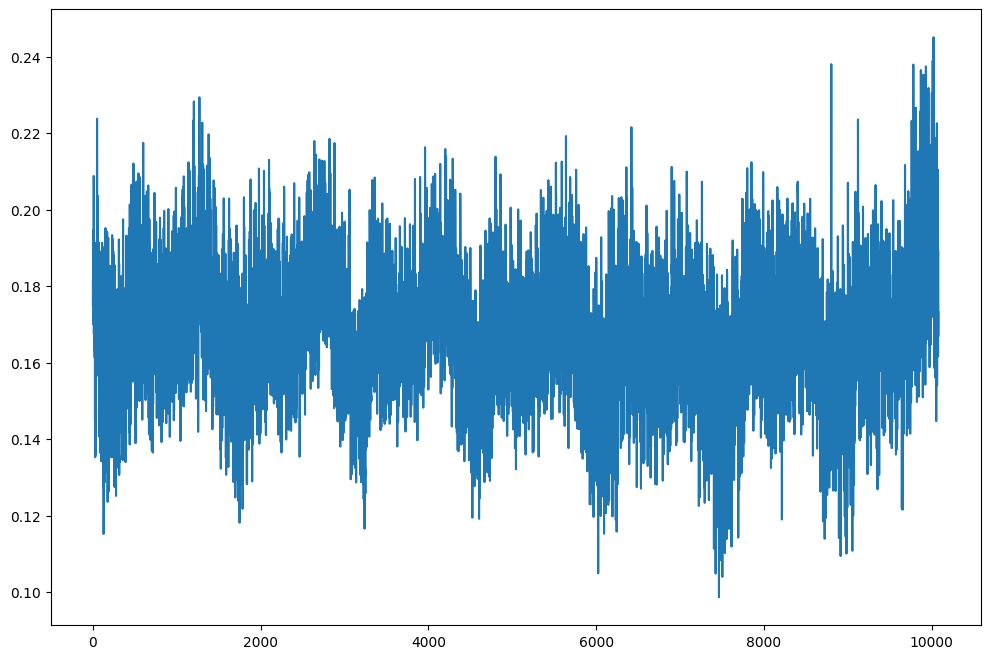

In [58]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')

In [59]:
len(pred_list)

10080

In [60]:
target = data.iloc[-split:]
target=list(target.values.reshape(-1,1))
score=SMAPE()(FloatTensor(list(np.array(pred_list).reshape(-1,1))),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 4.491851806640625 %


In [61]:
pred_list

[0.1813480705022812,
 0.17483720183372498,
 0.18326297402381897,
 0.18387135863304138,
 0.1769765317440033,
 0.17789573967456818,
 0.17004702985286713,
 0.1947452425956726,
 0.1770331710577011,
 0.17837682366371155,
 0.20882175862789154,
 0.20615555346012115,
 0.16740377247333527,
 0.17601937055587769,
 0.19208551943302155,
 0.1648401916027069,
 0.1788790374994278,
 0.16851989924907684,
 0.16340196132659912,
 0.17917880415916443,
 0.18094810843467712,
 0.18151359260082245,
 0.16135992109775543,
 0.19133764505386353,
 0.1611839383840561,
 0.1447708010673523,
 0.15803512930870056,
 0.15020456910133362,
 0.13526374101638794,
 0.13744647800922394,
 0.16065116226673126,
 0.15589246153831482,
 0.14180004596710205,
 0.167517751455307,
 0.14907844364643097,
 0.13594362139701843,
 0.1409468650817871,
 0.15408261120319366,
 0.1561739146709442,
 0.1586485207080841,
 0.188507080078125,
 0.18284334242343903,
 0.172881618142128,
 0.18637779355049133,
 0.15773212909698486,
 0.15809443593025208,
 0.17

In [62]:
len(target)

10080

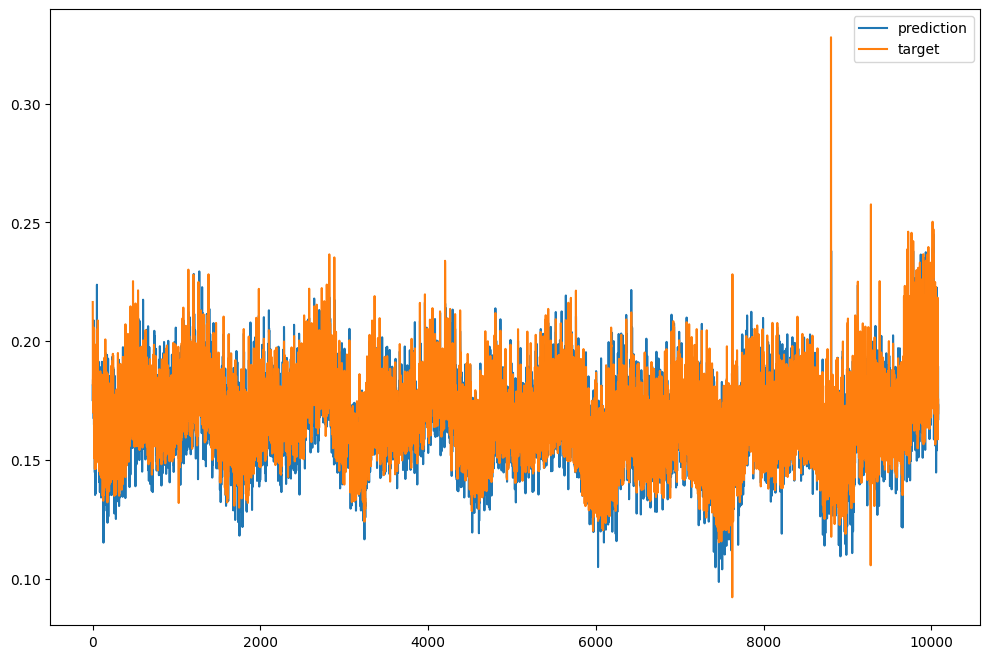

In [63]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list[:],label='prediction')
axes.plot(np.arange(1,10081),target[:],label='target')
axes.legend()

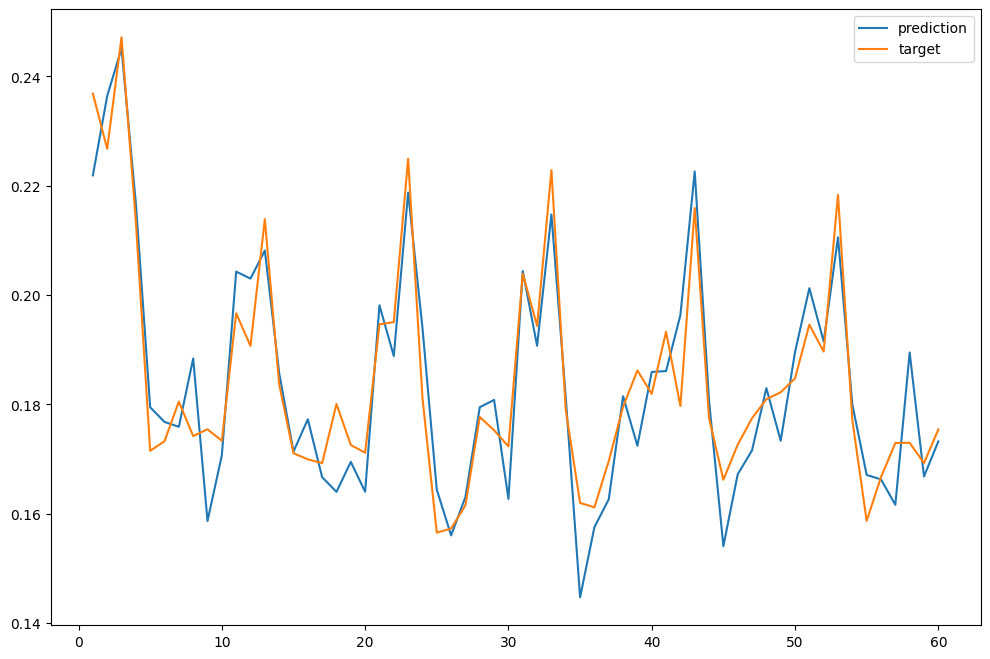

In [64]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

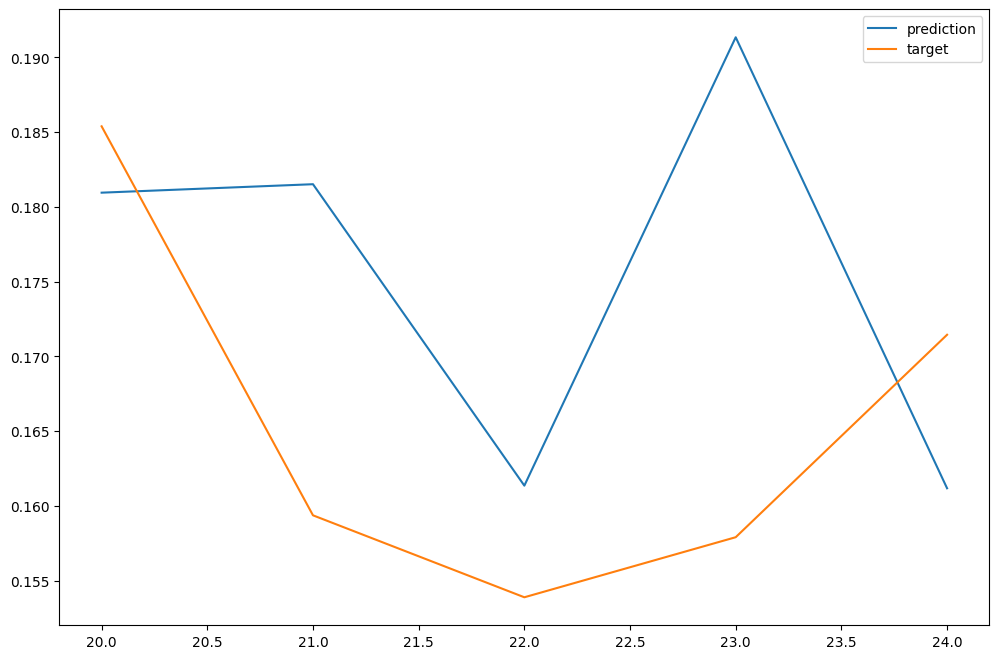

In [65]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(20,25),pred_list[20:25],label='prediction')
axes.plot(np.arange(20,25),target[20:25],label='target')
axes.legend()

In [66]:
np.mean(time_list)

0.8661247372390732

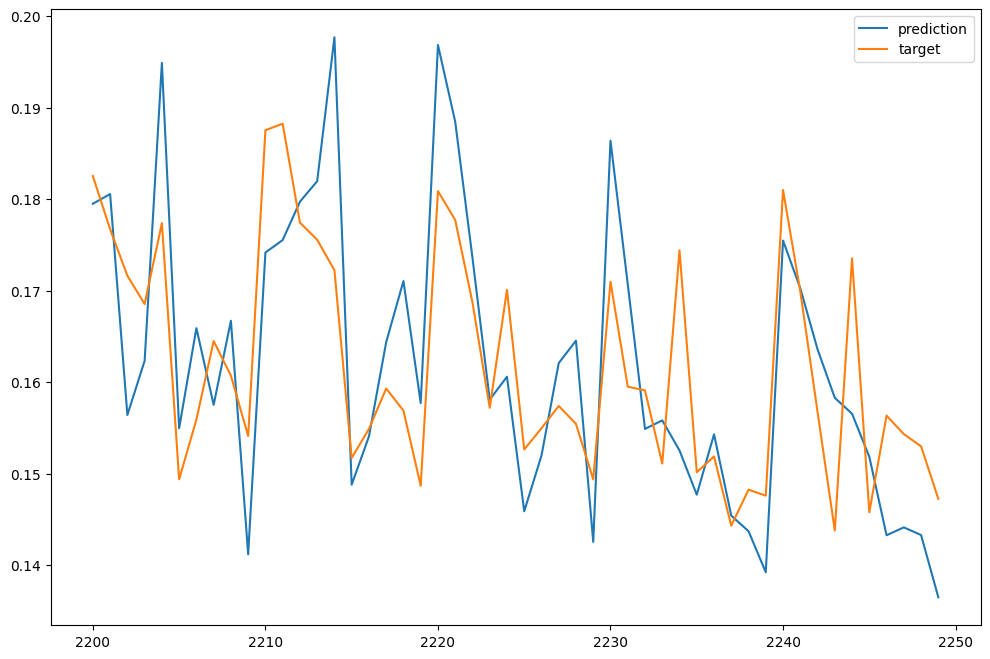

In [67]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(2200,2250),pred_list[2200:2250],label='prediction')
axes.plot(np.arange(2200,2250),target[2200:2250],label='target')
axes.legend()